# Keras

深層学習ライブラリ．
Kerasは，ユーザが使いやすいように設計されたAPI．TensorFlowやTheano上で動く．

Kerasで出来ること
1. 文章の自動生成
2. 画像認識
3. botの作成

メリット
- 初学者が，比較的短いソースコードで実装できる．
- 可読性が高い．
- エラー時にフィードバックが明確でわかりやすい．

In [ ]:
import keras

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from sklearn.model_selection import train_test_split, StratifiedKFold
from keras.utils import np_utils

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt


In [ ]:
df = pd.read_csv('/content/breast_cancer_imbalance.csv')

In [ ]:
skf = StratifiedKFold(n_splits = 5, shuffle = True)
df["fold"] = -1
for fold, (train_idx, test_idx) in enumerate(skf.split(X = df, y = df["target"])):
    df.loc[test_idx, "fold"] = fold
print(df["fold"].value_counts())

fold = 0
train = df.loc[df["fold"] != fold].copy()
test = df.loc[df["fold"] == fold].copy()
print(train.shape, test.shape)

feat_cols = train.drop(columns = ["fold", "target"]).columns.tolist()
print(feat_cols)

X_train = train[feat_cols]
X_test = test[feat_cols]
y_train = train["target"]
y_test = test["target"]

0    80
1    80
4    80
3    80
2    80
Name: fold, dtype: int64
(320, 32) (80, 32)
['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'mean fractal dimension', 'radius error', 'texture error', 'perimeter error', 'area error', 'smoothness error', 'compactness error', 'concavity error', 'concave points error', 'symmetry error', 'fractal dimension error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry', 'worst fractal dimension']


In [ ]:
Xy_train = pd.concat([X_train, y_train], axis=1)

In [ ]:
skf = StratifiedKFold(n_splits = 5, shuffle = True)
Xy_train["fold"] = -1
for fold, (train_idx, test_idx) in enumerate(skf.split(X = Xy_train, y = Xy_train["target"])):
    df.loc[test_idx, "fold"] = fold

fold = 0
train = Xy_train.loc[df["fold"] != fold].copy()
test = Xy_train.loc[df["fold"] == fold].copy()
print(train.shape, test.shape)

feat_cols = train.drop(columns = ["fold", "target"]).columns.tolist()
print(feat_cols)

X_train = train[feat_cols]
X_val = test[feat_cols]
y_train = train['target']
y_val = test['target']

(269, 32) (51, 32)
['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'mean fractal dimension', 'radius error', 'texture error', 'perimeter error', 'area error', 'smoothness error', 'compactness error', 'concavity error', 'concave points error', 'symmetry error', 'fractal dimension error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry', 'worst fractal dimension']


In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
X_val = scaler.fit_transform(X_val)

## 2値分類タスク

今回は，乳がんの診察データを使用し，患者が悪性か良性かを分類する．RNNやLSTMによる時系列数値データ予測ではない．

- SequentialモデルとFunctional API 

 ニューラルネットワークの構造は複雑であり，定義することが困難である．よって，構造(モデル)を簡略化することが可能．それが可能なモデルの一つがSequentialモデルである．
 Functional APIは，複数の出力を持ったモデルや有向非巡回グラフ，共有レイヤーを持ったモデルといった，Sequential モデルではできないような複雑なモデルが定義できる．

 今回は，Sequential モデルを使用する．

- レイヤーの追加

 .add() でレイヤーを追加できる．

- Dense
 
 レイヤーの種類で全結合を意味する．個々のノードが次のレイヤーのノード全てに繋がる．以下は，Denseの引数．

  - units(出力次元数)
   
   次のレイヤーのノードに入力される次元数(エッジの数)．units = 5 の場合，次のレイヤーの各ノードに対して，5つのデータが出力される．

  - activation(活性化関数)
   
   そのレイヤーの出力刺激量を計算する関数を指定する．

  - input_shape

   モデルはどのような入力のshapeを想定しているのかを知る必要がある．そのため，Sequentialモデルの最初のレイヤーにのみ入力のshapeの情報を与える必要がある．この引数にはshapeを示すタプルを与える．このタプルの要素は整数か Noneを取る．Noneは任意の正の整数を期待することを意味する．
  
  - input_dim

   2次元の層では input_dim引数を指定することで入力のshapeを指定できる．同様に，3次元のレイヤーでは input_dim引数と input_length引数を指定することで入力のshapeを指定できる．

- compile
  
  初期化したモデルで学習する際の，損失関数や最適化の方法を設定する．

- summary

  モデルに対しsummary()を呼び出すことで，モデルのすべての層の名前とタイプ，出力の形(Noneはバッチサイズがいくつでも良いという意味)，パラメータ数が表示され，パラメータ数と調整可能なパラメータ，調整不可能なパラメータの無い数が表示される．

- get_seights, set_weights

  これらのメソッドによって，層のすべてのパラメータを読み書きできる．

### 分類における層について

| ハイパラメータ  | 二値分類  | 多ラベル分類 | 多クラス分類 |
|---|---|---|---|
| 入力層と中間層  | 回帰と同じ  | 回帰と同じ | 回帰と同じ |
| 出力ニューロン数  | 1  | ラベル毎に1 | クラス毎に1 |
| 出力層の活性化関数  | ロジスティック | ロジスティック | ソフトマックス |
| 損失関数  | 交差エントロピー  | 交差エントロピー | 交差エントロピー |


- シグモイド関数に関して

  シグモイド関数を一般化した関数がロジスティック関数であり，シグモイド関数はロジスティック関数の特殊形と言える．よって，出力層ではシグモイド関数を指定する．

今回は，0∼1を予測するため，出力層を'sigmoid'に設定する． 

In [ ]:
nn1 = 64
nn2 = 32
nn3 = 128

model = Sequential()
model.add(Dense(nn1, input_dim=(X_train.shape[1]), activation='relu'))
model.add(Dense(nn3, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(nn2, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid')) # softmax

In [ ]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['Recall']
    )

In [ ]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_38 (Dense)            (None, 64)                1984      
                                                                 
 dense_39 (Dense)            (None, 128)               8320      
                                                                 
 dense_40 (Dense)            (None, 32)                4128      
                                                                 
 dropout_8 (Dropout)         (None, 32)                0         
                                                                 
 dense_41 (Dense)            (None, 1)                 33        
                                                                 
Total params: 14,465
Trainable params: 14,465
Non-trainable params: 0
_________________________________________________________________


- バッチサイズ

損失関数を最小化して最適なパラメータチューニングを行うためのに勾配降下法が使われる．多くの場合，ミニバッチ勾配降下法と確率的勾配降下法の間をとった手法が使われ，データセットを複数のサブセットに分ける必要がある(学習データとテストデータに分けることとは異なる)．

複数に分けたサブセットに含まれるデータ数をバッチサイズという．バッチサイズは機械学習の分野の慣習1として2のn乗の値が使われることが多く，32, 64, 128, 256, 512, 1024, 2048辺りがよく使われる．

- イテレーション数

イテレーション数とは，データセットに含まれるデータが少なくとも1回は学習に用いられるために必要な学習回数であり，バッチサイズが決まれば，必然的に決定される．

- エポック数

1. データセットをバッチサイズに従ってN個のサブセットに分ける．
2. 各サブセットを学習に回す．つまり，N回学習を繰り返す．

エポック数とは，1と2のプロセスを繰り返し，実行する回数を意味する．

In [ ]:
train_history = model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=200, 
    verbose=-1,
    validation_data=(X_val, y_val)
    )

Epoch 1/200
Epoch 2/200
Epoch 3/200
Epoch 4/200
Epoch 5/200
Epoch 6/200
Epoch 7/200
Epoch 8/200
Epoch 9/200
Epoch 10/200
Epoch 11/200
Epoch 12/200
Epoch 13/200
Epoch 14/200
Epoch 15/200
Epoch 16/200
Epoch 17/200
Epoch 18/200
Epoch 19/200
Epoch 20/200
Epoch 21/200
Epoch 22/200
Epoch 23/200
Epoch 24/200
Epoch 25/200
Epoch 26/200
Epoch 27/200
Epoch 28/200
Epoch 29/200
Epoch 30/200
Epoch 31/200
Epoch 32/200
Epoch 33/200
Epoch 34/200
Epoch 35/200
Epoch 36/200
Epoch 37/200
Epoch 38/200
Epoch 39/200
Epoch 40/200
Epoch 41/200
Epoch 42/200
Epoch 43/200
Epoch 44/200
Epoch 45/200
Epoch 46/200
Epoch 47/200
Epoch 48/200
Epoch 49/200
Epoch 50/200
Epoch 51/200
Epoch 52/200
Epoch 53/200
Epoch 54/200
Epoch 55/200
Epoch 56/200
Epoch 57/200
Epoch 58/200
Epoch 59/200
Epoch 60/200
Epoch 61/200
Epoch 62/200
Epoch 63/200
Epoch 64/200
Epoch 65/200
Epoch 66/200
Epoch 67/200
Epoch 68/200
Epoch 69/200
Epoch 70/200
Epoch 71/200
Epoch 72/200
Epoch 73/200
Epoch 74/200
Epoch 75/200
Epoch 76/200
Epoch 77/200
Epoch 78

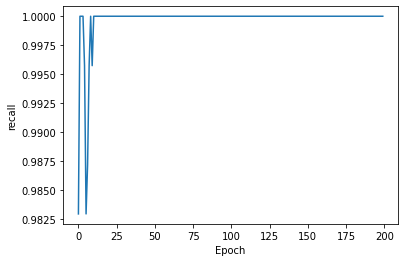

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.plot(train_history.history['recall'])
ax.set_xlabel('Epoch')
ax.set_ylabel('recall')
plt.show()

In [ ]:
scores = model.evaluate(X_train, y_train)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1] * 100))

9/9 [==============================] - 0s 3ms/step - loss: 8.3720e-06 - recall: 1.0000
recall: 100.00%


In [ ]:
print(model.metrics_names)
print(scores)

['loss', 'recall']
[8.372049705940299e-06, 1.0]


In [ ]:
from sklearn.metrics import recall_score, accuracy_score, f1_score, confusion_matrix, roc_auc_score


In [ ]:
y_pred = np.round(model.predict(X_test))
#print(y_pred)

[[1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


In [ ]:
accuracy = accuracy_score(list(y_test.values), y_pred)

print(accuracy)

0.9875


In [ ]:
confusion = confusion_matrix(list(y_test.values), y_pred)
print(confusion)

recall = recall_score(list(y_test.values), y_pred)
f1 = f1_score(list(y_test.values), y_pred)

print(recall)
print(f1)

[[ 8  1]
 [ 0 71]]
1.0
0.993006993006993


In [ ]:
print(roc_auc_score(y_test, y_pred))

0.9444444444444444


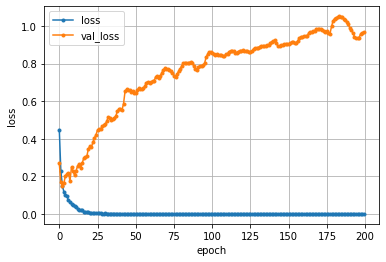

In [ ]:
# Lossのプロット
loss = train_history.history['loss']
val_loss = train_history.history['val_loss']
epochs = len(loss)
plt.plot(range(epochs), loss, marker = '.', label = 'loss')
plt.plot(range(epochs), val_loss, marker = '.', label = 'val_loss')
plt.legend(loc = 'best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

正解値と予測値の散布図

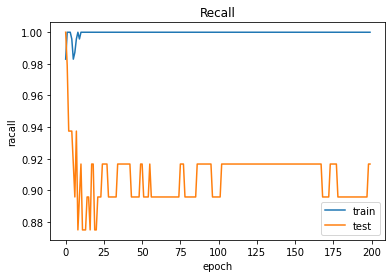

In [ ]:
# Recallのプロット
plt.figure()
plt.title('Recall')
plt.xlabel('epoch')
plt.ylabel('racall')
plt.plot(train_history.history['recall'], label='train')
plt.plot(train_history.history['val_recall'], label='test')
plt.legend()